In [1]:
class bcolors:
    OK = '\033[92m' #GREEN
    WARNING = '\033[93m' #YELLOW
    FAIL = '\033[91m' #RED
    RESET = '\033[0m' #RESET COLOR

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

from pandas.core.common import flatten
import random
import glob

import albumentations as A
from albumentations.pytorch import ToTensorV2

from GPUtil import showUtilization as gpu_usage
from numba import cuda

print(f'{bcolors.OK}Enviroment setup complete!{bcolors.RESET}')

Enviroment setup complete!


In [3]:
def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()  

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  1% |  4% |
|  1 |  0% |  0% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  4% |  5% |
|  1 |  0% |  0% |


In [4]:
class Transforms:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, *args, **kwargs):
        return self.transforms(image=np.array(img))['image']

In [5]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    'train': A.Compose([A.Resize(224 , 224), A.Normalize(mean, std), ToTensorV2()]),
    'test': A.Compose([A.Resize(224 , 224), A.Normalize(mean, std), ToTensorV2()])
}

In [6]:
data_dir = 'D:\sl\images'
sets = ['train', 'test']

In [7]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform =Transforms(transforms=data_transforms[x])) for x in ['train', 'test']}

In [8]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True) for x in ['train', 'test']}

In [9]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('train: {} test: {}'.format(dataset_sizes['train'], dataset_sizes['test']))
print(class_names)

train: 20265 test: 5066
['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']


In [10]:
inputs, classes = next(iter(dataloaders['train']))
print(inputs.size())

torch.Size([4, 3, 224, 224])


In [11]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)
print(f"Using {device} device")

['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']
Using cuda:0 device


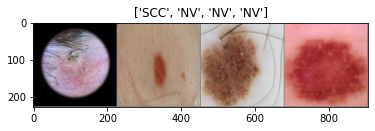

In [12]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [13]:
def train_model(model, cirterion, optimizer, scheduler, num_epochs=25):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epoch-1}')
    print('-' * 10)

    for phase in ['train', 'test']:
      if phase =='train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0

      # Iterate over data.
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        # track history only if train
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = cirterion(outputs, labels)

          #backward + optimize only if in train
          if phase == 'train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      
      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      print(f'{phase} Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')

      if phase == 'test' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print()
  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m { time_elapsed % 60:.0f}s')
  print(f'Best val Acc: {best_acc:4f}')

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model

In [14]:
epoch, num_epoch = 2, 10
print(f'Epoch {epoch}/{num_epoch-1}')
print('-' * 10)

Epoch 2/9
----------


In [ ]:
# Finetuning the convnet: 
# Load a pretrained model and reset final fully connected layer.

In [15]:
model = models.resnet152(pretrained=True)
num_ftrs = model.fc.in_features

E:\conda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\conda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 8)
model = model.to(device)

In [17]:
criterion = nn.CrossEntropyLoss()

In [18]:
# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [ ]:
# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer’s update

In [19]:
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [20]:
model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 1.0822, Acc: 0.6180
test Loss: 0.8482, Acc: 0.7073

Epoch 1/9
----------
train Loss: 0.8992, Acc: 0.6826
test Loss: 0.8171, Acc: 0.7211

Epoch 2/9
----------
train Loss: 0.7783, Acc: 0.7278
test Loss: 0.8193, Acc: 0.7347

Epoch 3/9
----------
train Loss: 0.6565, Acc: 0.7718
test Loss: 0.8815, Acc: 0.7142

Epoch 4/9
----------
train Loss: 0.5401, Acc: 0.8107
test Loss: 0.8382, Acc: 0.7509

Epoch 5/9
----------
train Loss: 0.4486, Acc: 0.8460
test Loss: 0.8189, Acc: 0.7438

Epoch 6/9
----------
train Loss: 0.3512, Acc: 0.8797
test Loss: 0.8061, Acc: 0.7661

Epoch 7/9
----------
train Loss: 0.2268, Acc: 0.9309
test Loss: 0.8374, Acc: 0.7687

Epoch 8/9
----------
train Loss: 0.1796, Acc: 0.9469
test Loss: 0.8162, Acc: 0.7756

Epoch 9/9
----------
train Loss: 0.1688, Acc: 0.9496
test Loss: 0.8173, Acc: 0.7827

Training complete in 401m 43s
Best val Acc: 0.782669


In [21]:
#ConvNet as fixed feature extractor:
# Here, we need to freeze all the network except the final layer.
# We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 8)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

E:\conda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/9
----------
train Loss: 1.3458, Acc: 0.5473
test Loss: 1.3400, Acc: 0.5983

Epoch 1/9
----------
train Loss: 1.3154, Acc: 0.5600
test Loss: 1.3260, Acc: 0.5900

Epoch 2/9
----------
train Loss: 1.3135, Acc: 0.5577
test Loss: 1.2059, Acc: 0.6196

Epoch 3/9
----------
train Loss: 1.2852, Acc: 0.5613
test Loss: 1.2358, Acc: 0.6094

Epoch 4/9
----------
train Loss: 1.2794, Acc: 0.5656
test Loss: 1.1401, Acc: 0.6234

Epoch 5/9
----------
train Loss: 1.2995, Acc: 0.5594
test Loss: 1.2703, Acc: 0.6068

Epoch 6/9
----------
train Loss: 1.2879, Acc: 0.5679
test Loss: 1.1940, Acc: 0.6271

Epoch 7/9
----------
train Loss: 1.0744, Acc: 0.6132
test Loss: 1.0575, Acc: 0.6386

Epoch 8/9
----------
train Loss: 1.0607, Acc: 0.6169
test Loss: 1.0435, Acc: 0.6380

Epoch 9/9
----------
train Loss: 1.0532, Acc: 0.6156
test Loss: 1.0025, Acc: 0.6465

Training complete in 139m 14s
Best val Acc: 0.646467
